# **뇌졸중 예측 ML 모델**



### Variables:
* id: 환자 고유번호
* gender: 성별
* age: 나이
* hypertension: 고혈합 유무; [0, 1]
* heart_disease: 심장병 유무; [0, 1]
* ever_married: 결혼 경험 유무; [0, 1]
* work_type: 직업 유형; [교육, 민간 부문, 무직, 자영업, 공무직]
* Residence_type: 거주지 [도시, 시골]
* avg_glucose_level: 평균 혈당 수치
* bmi: 체질량지수 (몸무게/키 ^2)
* smoking_status: 흡연 상태 [비흡연자, 금연, 흡연자]
* stroke: 뇌졸중 경험 유무 [0, 1]

## **EDA 및 데이터 전처리**

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('./train_strokes.csv')
df = data.copy()
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43395,56196,Female,10.0,0,0,No,children,Urban,58.64,20.4,never smoked,0
43396,5450,Female,56.0,0,0,Yes,Govt_job,Urban,213.61,55.4,formerly smoked,0
43397,28375,Female,82.0,1,0,Yes,Private,Urban,91.94,28.9,formerly smoked,0
43398,27973,Male,40.0,0,0,Yes,Private,Urban,99.16,33.2,never smoked,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


In [3]:
# 데이터 변수 이름 소문자로 통일
df.columns = df.columns.str.lower()
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [4]:
# id 고유번호로 중복된 데이터 확인
df.duplicated('id').sum()

0

In [5]:
# 분석에 불필요한 id 변수 제거
df.drop(['id'], axis=1, inplace=True)

df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [6]:
# 데이터셋에서 결측치 확인
df.isnull().sum()

gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

In [7]:
# 흡연 상태 데이터의 많은 부분인 3분의 1이 결측치이므로 결측치를 제거하기보다 모름으로 대체
df['smoking_status'].fillna('unknown', inplace=True)
df['smoking_status'].value_counts()

never smoked       16053
unknown            13292
formerly smoked     7493
smokes              6562
Name: smoking_status, dtype: int64

In [8]:
# 데이터 고유값 확인
    # 수치형 데이터 제외
for col in df.drop(['age', 'avg_glucose_level', 'bmi'], axis=1):
    print(col, ':', df[col].unique())

gender : ['Male' 'Female' 'Other']
hypertension : [0 1]
heart_disease : [0 1]
ever_married : ['No' 'Yes']
work_type : ['children' 'Private' 'Never_worked' 'Self-employed' 'Govt_job']
residence_type : ['Rural' 'Urban']
smoking_status : ['unknown' 'never smoked' 'formerly smoked' 'smokes']
stroke : [0 1]


In [9]:
#성별 분포 확인
df['gender'].value_counts()

Female    25665
Male      17724
Other        11
Name: gender, dtype: int64

In [10]:
# 성별에 Other인 데이터의 비율이 너무 작아서 Other에 대한 유의미한 결과 도출이 불가할 것 같아 데이터 삭제
df = df[df['gender'] != 'Other']

df['gender'].value_counts()

Female    25665
Male      17724
Name: gender, dtype: int64

count    41931.000000
mean        28.605156
std          7.770186
min         10.100000
25%         23.200000
50%         27.700000
75%         32.900000
max         97.600000
Name: bmi, dtype: float64

median: 27.7


<Axes: xlabel='bmi'>

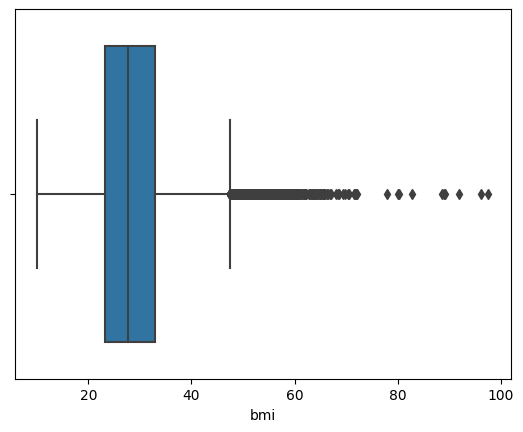

In [11]:
# bmi 특성 분포 확인
import seaborn as sns

print(df['bmi'].describe())
print('\nmedian:', df['bmi'].median())
sns.boxplot(x=df['bmi'])

In [12]:
# 상당 부분의 극단치가 존재함으로 중앙값 사용
df['bmi'].fillna(df['bmi'].median(), inplace=True)

df.isnull().sum()

/var/folders/dp/dk2xwgqs5g11x29n8gqjstsh0000gn/T/ipykernel_91070/4141608763.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bmi'].fillna(df['bmi'].median(), inplace=True)


gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [13]:
# 혈당 수치를 당뇨진단범위에 의하여 3단계로 나눔
  # 대한진단검사의학회에 의하면 혈당 수치가 정상은 ~100mg/dl, 당뇨병전기는 100~126mg/dl, 당뇨병은 126~mg/dl로 분류
df['avg_glucose_level'] = pd.cut(x=df['avg_glucose_level'], 
                                 bins=[0, 100, 126, np.inf], 
                                 labels=['normal', 'prediabetic', 'diabetic'])

# 체질량지수를 4단계로 나눔
df['bmi'] = pd.cut(x=df['bmi'],
                   bins=[0, 18.5, 25, 30, np.inf],
                   labels=['underweight', 'normal', 'overweight', 'obese'])

# 특성별 고유값 확인
for col in df.drop(['age'], axis=1):
    print(col, ':', df[col].unique())

gender : ['Male' 'Female']
hypertension : [0 1]
heart_disease : [0 1]
ever_married : ['No' 'Yes']
work_type : ['children' 'Private' 'Never_worked' 'Self-employed' 'Govt_job']
residence_type : ['Rural' 'Urban']
avg_glucose_level : ['normal', 'prediabetic', 'diabetic']
Categories (3, object): ['normal' < 'prediabetic' < 'diabetic']
bmi : ['underweight', 'obese', 'normal', 'overweight']
Categories (4, object): ['underweight' < 'normal' < 'overweight' < 'obese']
smoking_status : ['unknown' 'never smoked' 'formerly smoked' 'smokes']
stroke : [0 1]


/var/folders/dp/dk2xwgqs5g11x29n8gqjstsh0000gn/T/ipykernel_91070/742684835.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['avg_glucose_level'] = pd.cut(x=df['avg_glucose_level'],
/var/folders/dp/dk2xwgqs5g11x29n8gqjstsh0000gn/T/ipykernel_91070/742684835.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bmi'] = pd.cut(x=df['bmi'],


In [14]:
# 타겟 분포 확인
df.stroke.value_counts(normalize=True)

# 타켓 분포가 불균형

0    0.981954
1    0.018046
Name: stroke, dtype: float64

## **데이터 시각화**

### **Distribution by Age, Average Glucose Level, and BMI**

* 나이별로 보았을 때 35세 이상부터 나이가 높아질수록 뇌졸중을 경험한 사람이 많아졌고 65세 이상의 고령자 그룹이 가장 많이 경험
* 혈당수치를 보았을 때 뇌졸중을 특별히 더 많이 경험한 그룹이 없음
* BMI 그룹에선 평균 BMI 수치 이상의 그룹들이 뇌졸중을 경험하였고 과체중, 비만 그룹에서 많이 경험

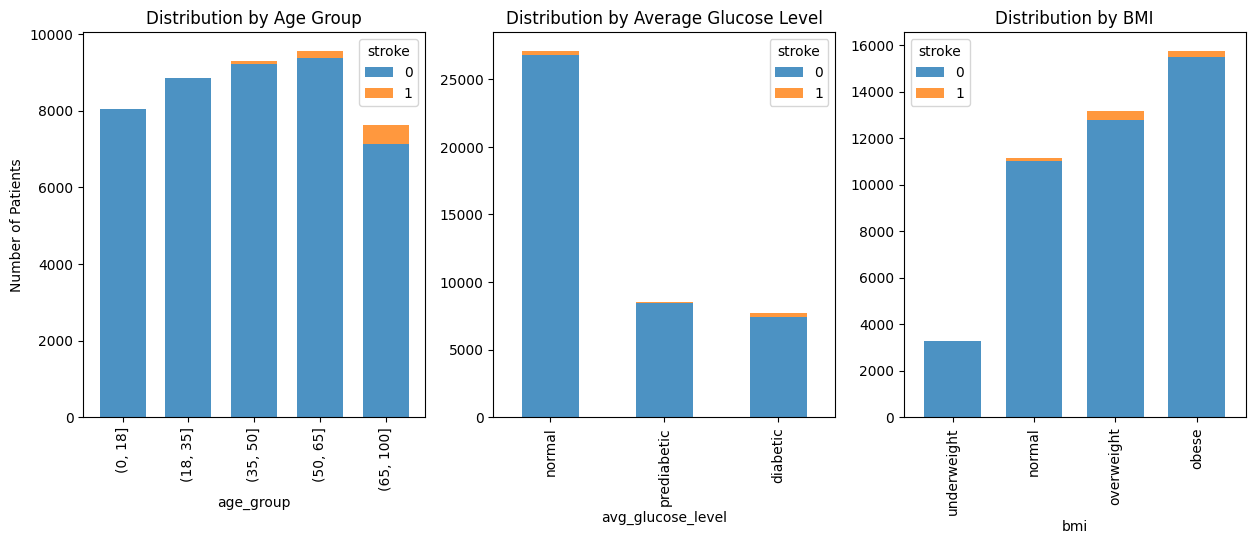

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

# figure 1
df1 = df.copy()
df1['age_group'] = pd.cut(df1['age'], bins=[0, 18, 35, 50, 65, 100]) # create bins for age

df_age = df1.groupby(['age_group', 'stroke']).size().unstack()
df_age.plot(kind='bar', stacked=True, ax=ax1, width=.7, alpha=.8)
ax1.set_ylabel('Number of Patients')
ax1.set_title('Distribution by Age Group')


#figure 2
df_glucose = df1.groupby(['avg_glucose_level', 'stroke']).size().unstack()
df_glucose.plot(kind='bar', stacked=True, ax= ax2, alpha=.8)
ax2.set_title('Distribution by Average Glucose Level')


#figure 3
df_bmi = df1.groupby(['bmi', 'stroke']).size().unstack()
df_bmi.plot(kind='bar', stacked=True, ax= ax3, width=.7, alpha=.8)
ax3.set_title('Distribution by BMI')

plt.show()

### **Distribution by Gender**

* 성별분포를 보았을 때 대략 여자 59%, 남자 41%
* 두 성별 모두 뇌졸중을 경험한 사람은 대략 2%로 동일
* 성별간 차이는 미비

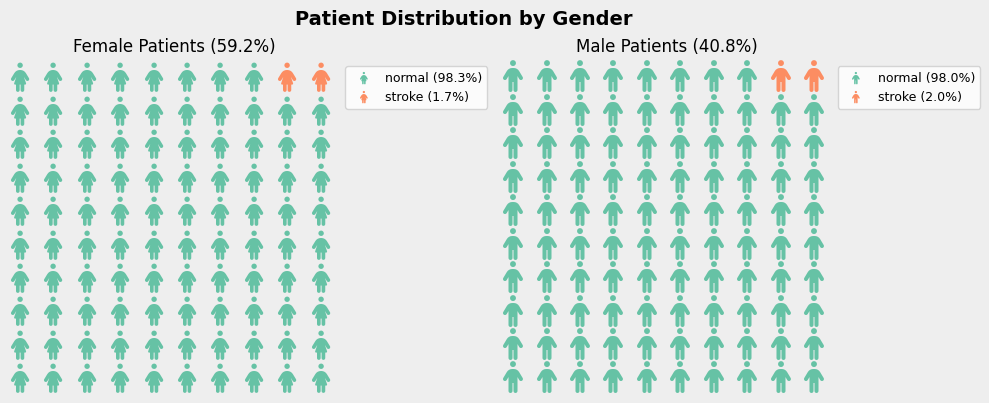

In [155]:
from pywaffle import Waffle

df_sub = df.groupby('stroke')['gender'].value_counts().copy()

#Glance of gender data:
    # stroke  gender
    # 0       Female    25234
    #         Male      17372
    # 1       Female      431
    #         Male        352

female_total = df['gender'].value_counts()[0]
male_total = df['gender'].value_counts()[1]

total = female_total + male_total

female_stroke = round(df_sub[1][0] / female_total * 100, 1)
male_stroke = round(df_sub[1][1] / male_total * 100, 1)
female_normal = round(df_sub[0][0] / female_total * 100, 1)
male_normal = round(df_sub[0][1] / male_total * 100, 1)

female_per = round(female_total / total * 100, 1)
male_per = round(male_total / total * 100, 1)


fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    figsize=(10, 10),

    plots={
        121: {
        'values':[female_normal, female_stroke],
        'icons':'female',
        'vertical':True,
        'icon_size':21,
        'icon_legend':True,
        'legend':{
            'labels':[f'normal ({female_normal}%)', f'stroke ({female_stroke}%)'],
            'loc':'upper left',
            'bbox_to_anchor':(1,1),
            'fontsize':9
            },
        'title':{
            'label':f'Female Patients ({female_per}%)',
            'loc':'center',
            'fontsize':12
            }
        },

        122: {
        'values':[male_normal, male_stroke],
        'icons':'male',
        'vertical':True,
        'icon_size':23,
        'icon_legend':True,
        'legend':{
            'labels':[f'normal ({male_normal}%)', f'stroke ({male_stroke}%)'],
            'loc':'upper left',
            'bbox_to_anchor':(1,1),
            'fontsize':9
            },
        'title':{
            'label':f'Male Patients ({male_per}%)',
            'loc':'center',
            'fontsize':12
            }
        }
    }
)

fig.text(.3, .7,'Patient Distribution by Gender', fontsize=14, fontweight='bold')
fig.set_facecolor('#EEEEEE')

### **Distribution by Hypertension**

* 대략 정상 혈압을 가진 사람 91%, 고혈압을 가진 사람 9%
* 정상 혈압의 사람 중 1.5%, 고혈압을 가진 사람 중 4.9%가 뇌졸중을 경험
* 비율적으로 고혈압을 가진 사람이 **3배** 이상 뇌졸중을 겅험

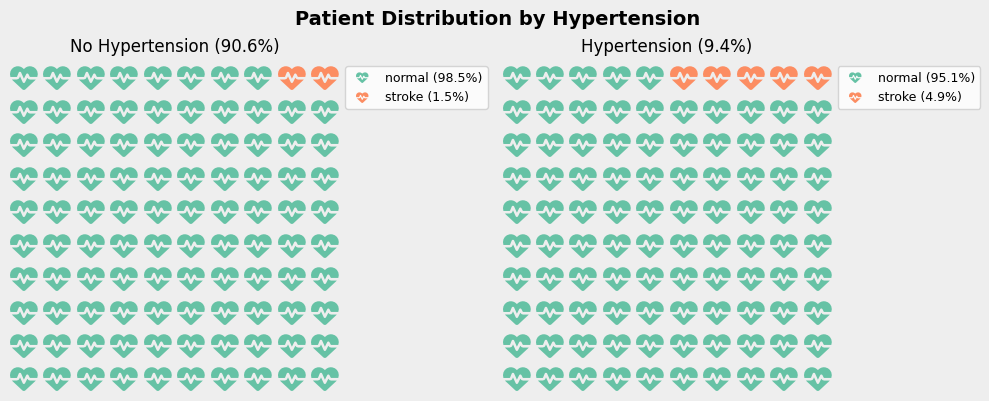

In [156]:
df_sub = df.groupby('stroke')['hypertension'].value_counts().copy()

# A glance of hypertension data:
#     stroke  hypertension
#     0       0               38745
#             1                3861
#     1       0                 583
#             1                 200


no_total = df['hypertension'].value_counts()[0]
yes_total = df['hypertension'].value_counts()[1]

total = no_total + yes_total

no_normal = round(df_sub[0][0] / no_total * 100, 1)
yes_normal = round(df_sub[0][1] / yes_total * 100, 1)
no_stroke = round(df_sub[1][0] / no_total * 100, 1)
yes_stroke = round(df_sub[1][1] / yes_total * 100, 1)

no_per = round(no_total / total * 100, 1)
yes_per = round(yes_total / total * 100, 1)


fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    figsize=(10, 10),

    plots={
        121: {
        'values':[no_normal, no_stroke],
        'icons':'heart-pulse',
        'vertical':True,
        'icon_size':20,
        'icon_legend':True,
        'legend':{
            'labels':[f'normal ({no_normal}%)', f'stroke ({no_stroke}%)'],
            'loc':'upper left',
            'bbox_to_anchor':(1,1),
            'fontsize':9
            },
        'title':{
            'label':f'No Hypertension ({no_per}%)',
            'loc':'center',
            'fontsize':12
            }
        },

        122: {
        'values':[yes_normal, yes_stroke],
        'icons':'heart-pulse',
        'vertical':True,
        'icon_size':20,
        'icon_legend':True,
        'legend':{
            'labels':[f'normal ({yes_normal}%)', f'stroke ({yes_stroke}%)'],
            'loc':'upper left',
            'bbox_to_anchor':(1,1),
            'fontsize':9
            },
        'title':{
            'label':f'Hypertension ({yes_per}%)',
            'loc':'center',
            'fontsize':12
            }
        }
    }
)

fig.text(.3, .7,'Patient Distribution by Hypertension', fontsize=14, fontweight='bold')
fig.set_facecolor('#EEEEEE')

### **Distribution by Heart Disease**

* 대략 건강한 사람 95%, 심장병을 가진 사람 5%
* 심장병이 없는 사람 중 1.5%, 심장병을 가진 사람 중 8.6%가 뇌졸중을 경험
* 비율적으로 심장병을 가진 사람이 5배 이상 뇌졸중을 경험

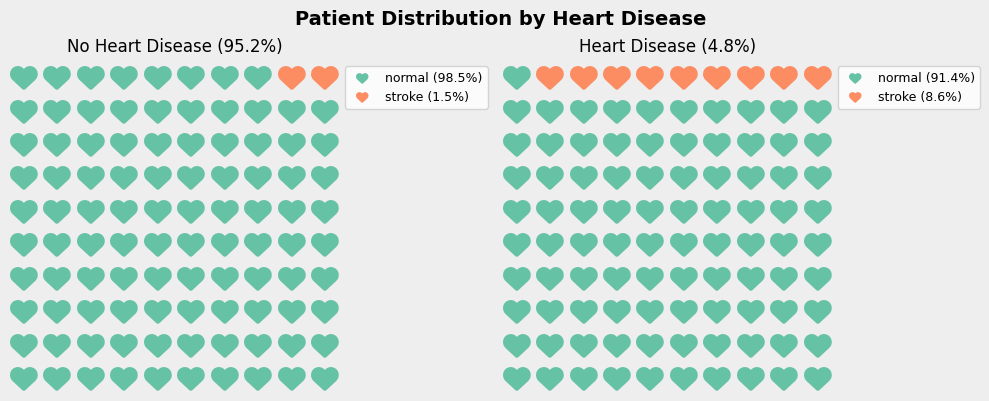

In [157]:
df_sub = df.groupby('stroke')['heart_disease'].value_counts().copy()

# A glance of hypertension data:
#     stroke  hypertension
#     0       0               38745
#             1                3861
#     1       0                 583
#             1                 200


no_total = df['heart_disease'].value_counts()[0]
yes_total = df['heart_disease'].value_counts()[1]

total = no_total + yes_total

no_normal = round(df_sub[0][0] / no_total * 100, 1)
yes_normal = round(df_sub[0][1] / yes_total * 100, 1)
no_stroke = round(df_sub[1][0] / no_total * 100, 1)
yes_stroke = round(df_sub[1][1] / yes_total * 100, 1)

no_per = round(no_total / total * 100, 1)
yes_per = round(yes_total / total * 100, 1)


fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    figsize=(10, 10),

    plots={
        121: {
        'values':[no_normal, no_stroke],
        'icons':'heart',
        'vertical':True,
        'icon_size':20,
        'icon_legend':True,
        'legend':{
            'labels':[f'normal ({no_normal}%)', f'stroke ({no_stroke}%)'],
            'loc':'upper left',
            'bbox_to_anchor':(1,1),
            'fontsize':9
            },
        'title':{
            'label':f'No Heart Disease ({no_per}%)',
            'loc':'center',
            'fontsize':12
            }
        },

        122: {
        'values':[yes_normal, yes_stroke],
        'icons':'heart',
        'vertical':True,
        'icon_size':20,
        'icon_legend':True,
        'legend':{
            'labels':[f'normal ({yes_normal}%)', f'stroke ({yes_stroke}%)'],
            'loc':'upper left',
            'bbox_to_anchor':(1,1),
            'fontsize':9
            },
        'title':{
            'label':f'Heart Disease ({yes_per}%)',
            'loc':'center',
            'fontsize':12
            }
        }
    }
)

fig.text(.3, .7,'Patient Distribution by Heart Disease', fontsize=14, fontweight='bold')
fig.set_facecolor('#EEEEEE')

### **Distribution by Marriage**

* 대략 결혼 경험이 없는 사람 36%, 결혼 경험이 있는 사람 64%
* 결혼 경험이 없는 사람 중 0.5, 결혼 경험이 있는 사람 중 2.5%가 뇌졸중을 경험
* 비율적으로 결혼 경험이 있는 사람이 5배 뇌졸중을 경험

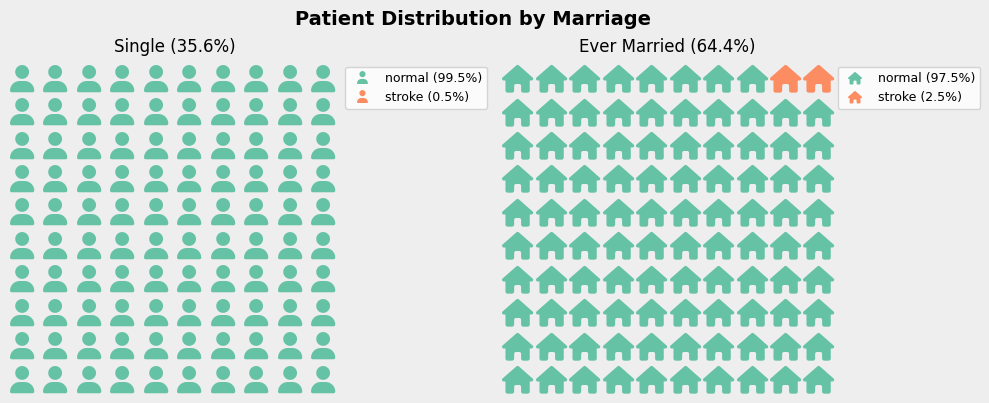

In [158]:
df_sub = df.groupby('stroke')['ever_married'].value_counts().copy()

# A glance of hypertension data:
    # stroke  ever_married
    # 0       Yes             27230
    #         No              15376
    # 1       Yes               703
    #         No                 80

# [0]가 결혼 경험이 있음, [1]가 없음
no_total = df['ever_married'].value_counts()[1]
yes_total = df['ever_married'].value_counts()[0]

total = no_total + yes_total

no_normal = round(df_sub[0][1] / no_total * 100, 1)
yes_normal = round(df_sub[0][0] / yes_total * 100, 1)
no_stroke = round(df_sub[1][1] / no_total * 100, 1)
yes_stroke = round(df_sub[1][0] / yes_total * 100, 1)

no_per = round(no_total / total * 100, 1)
yes_per = round(yes_total / total * 100, 1)


fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    figsize=(10, 10),

    plots={
        121: {
        'values':[no_normal, no_stroke],
        'icons':'user',
        'vertical':True,
        'icon_size':20,
        'icon_legend':True,
        'legend':{
            'labels':[f'normal ({no_normal}%)', f'stroke ({no_stroke}%)'],
            'loc':'upper left',
            'bbox_to_anchor':(1,1),
            'fontsize':9
            },
        'title':{
            'label':f'Single ({no_per}%)',
            'loc':'center',
            'fontsize':12
            }
        },

        122: {
        'values':[yes_normal, yes_stroke],
        'icons':'house',
        'vertical':True,
        'icon_size':20,
        'icon_legend':True,
        'legend':{
            'labels':[f'normal ({yes_normal}%)', f'stroke ({yes_stroke}%)'],
            'loc':'upper left',
            'bbox_to_anchor':(1,1),
            'fontsize':9
            },
        'title':{
            'label':f'Ever Married ({yes_per}%)',
            'loc':'center',
            'fontsize':12
            }
        }
    }
)

fig.text(.3, .7,'Patient Distribution by Marriage', fontsize=14, fontweight='bold')
fig.set_facecolor('#EEEEEE')

### **Distribution by Residence Type**

* 도시에서 사는 사람과 시골에서 사는 사람 둘 다 50% 정도
* 도시에서 사는 사람과 시골에서 사는 사람 동일하게 대략 2% 정도 뇌졸중 경험
* 사는 지역에 따른 차이는 없었음

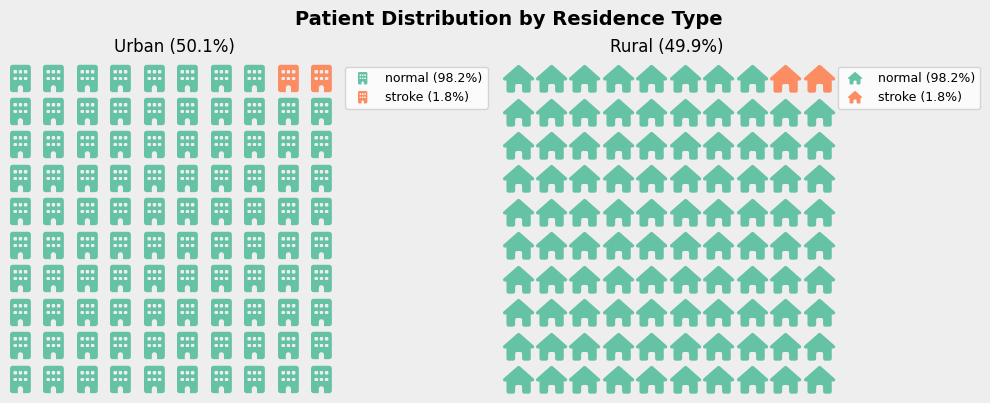

In [159]:
df_sub = df.groupby('stroke')['residence_type'].value_counts().copy()

# A glance of hypertension data:
#     stroke  residence_type
#     0       Urban             21352
#             Rural             21254
#     1       Urban               399
#             Rural               384


urban_total = df['residence_type'].value_counts()[0]
rural_total = df['residence_type'].value_counts()[1]

total = urban_total + rural_total

urban_normal = round(df_sub[0][0] / urban_total * 100, 1)
rural_normal = round(df_sub[0][1] / rural_total * 100, 1)
urban_stroke = round(df_sub[1][0] / urban_total * 100, 1)
rural_stroke = round(df_sub[1][1] / rural_total * 100, 1)

urban_per = round(urban_total / total * 100, 1)
rural_per = round(rural_total / total * 100, 1)


fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    figsize=(10, 10),

    plots={
        121: {
        'values':[urban_normal, urban_stroke],
        'icons':'building',
        'vertical':True,
        'icon_size':20,
        'icon_legend':True,
        'legend':{
            'labels':[f'normal ({urban_normal}%)', f'stroke ({urban_stroke}%)'],
            'loc':'upper left',
            'bbox_to_anchor':(1,1),
            'fontsize':9
            },
        'title':{
            'label':f'Urban ({urban_per}%)',
            'loc':'center',
            'fontsize':12
            }
        },

        122: {
        'values':[rural_normal, rural_stroke],
        'icons':'house',
        'vertical':True,
        'icon_size':20,
        'icon_legend':True,
        'legend':{
            'labels':[f'normal ({rural_normal}%)', f'stroke ({rural_stroke}%)'],
            'loc':'upper left',
            'bbox_to_anchor':(1,1),
            'fontsize':9
            },
        'title':{
            'label':f'Rural ({rural_per}%)',
            'loc':'center',
            'fontsize':12
            }
        }
    }
)

fig.text(.3, .7,'Patient Distribution by Residence Type', fontsize=14, fontweight='bold')
fig.set_facecolor('#EEEEEE')

### **Distribution by Smoking**

* 흡연 여부 분포: 비흡연(37%), 미확인(31%), 금연(17%), 흡연(15%)
* 그룹별 뇌졸중을 경험한 사람은 금연(3.0%) > 흡연(2.0%) > 비흡연(1.8%) > 미확인(1.1%)순으로 확인됐지만 흡연 여부간 큰 차이는 없었음

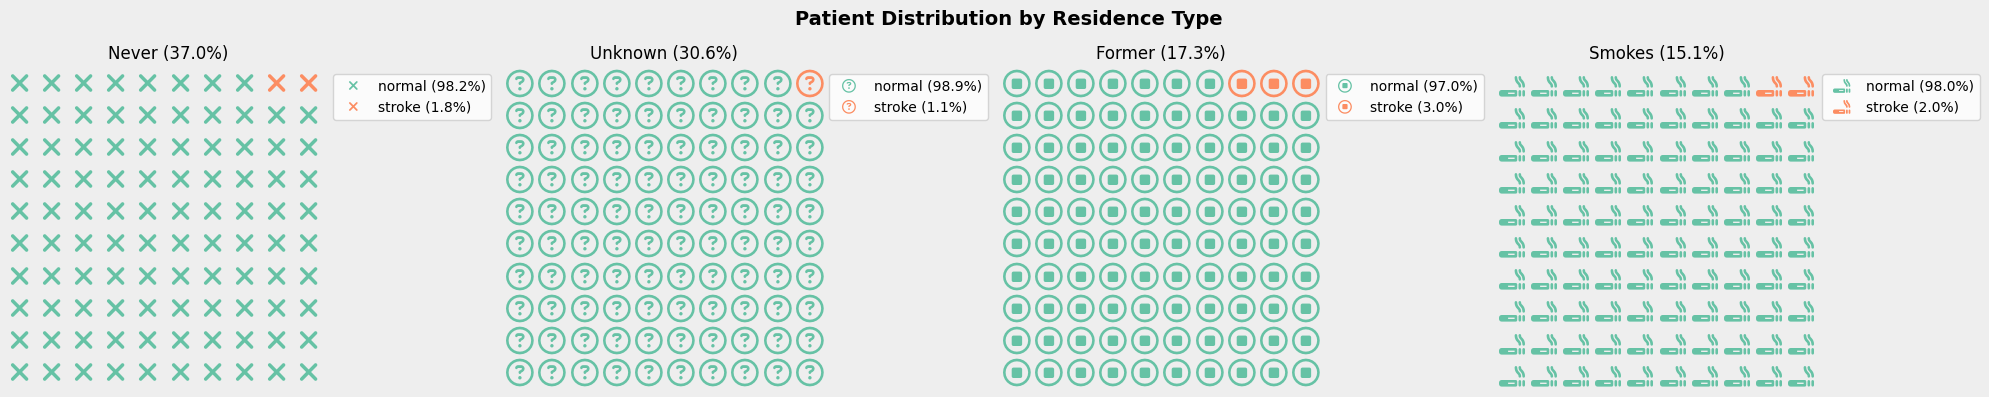

In [175]:
df_sub = df.groupby('stroke')['smoking_status'].value_counts().copy()

# A glance of hypertension data:
#     stroke  smoking_status 
#     0       never smoked       15767
#             unknown            13145
#             formerly smoked     7266
#             smokes              6428
#     1       never smoked         284
#             formerly smoked      221
#             unknown              145
#             smokes               133


never_total = df['smoking_status'].value_counts()[0]
unknown_total = df['smoking_status'].value_counts()[1]
former_total = df['smoking_status'].value_counts()[2]
smokes_total = df['smoking_status'].value_counts()[3]

total = never_total + unknown_total + former_total + smokes_total

never_normal = round(df_sub[0][0] / never_total * 100, 1)
unknown_normal = round(df_sub[0][1] / unknown_total * 100, 1)
former_normal = round(df_sub[0][2] / former_total * 100, 1)
smokes_normal = round(df_sub[0][3] / smokes_total * 100, 1)

never_stroke = round(df_sub[1][0] / never_total * 100, 1)
unknown_stroke = round(df_sub[1][2] / unknown_total * 100, 1)               # 데이터를 확인해보면 formerly smoked와 unknown이 normal과 순서가 다름
former_stroke = round(df_sub[1][1] / former_total * 100, 1)
smokes_stroke = round(df_sub[1][3] / smokes_total * 100, 1)

never_per = round(never_total / total * 100, 1)
unknown_per = round(unknown_total / total * 100, 1)
former_per = round(former_total / total * 100, 1)
smokes_per = round(smokes_total / total * 100, 1)


fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    figsize=(20, 20),

    plots={
        141: {
        'values':[never_normal, never_stroke],
        'icons':'xmark',
        'vertical':True,
        'icon_size':20,
        'icon_legend':True,
        'legend':{
            'labels':[f'normal ({never_normal}%)', f'stroke ({never_stroke}%)'],
            'loc':'upper left',
            'bbox_to_anchor':(1,1),
            'fontsize':10
            },
        'title':{
            'label':f'Never ({never_per}%)',
            'loc':'center',
            'fontsize':12
            }
        },

        142: {
        'values':[unknown_normal, unknown_stroke],
        'icons':'circle-question',
        'icon_style':'regular',
        'vertical':True,
        'icon_size':20,
        'icon_legend':True,
        'legend':{
            'labels':[f'normal ({unknown_normal}%)', f'stroke ({unknown_stroke}%)'],
            'loc':'upper left',
            'bbox_to_anchor':(1,1),
            'fontsize':10
            },
        'title':{
            'label':f'Unknown ({unknown_per}%)',
            'loc':'center',
            'fontsize':12
            }
        },

        143: {
        'values':[former_normal, former_stroke],
        'icons':'circle-stop',
        'icon_style':'regular',
        'vertical':True,
        'icon_size':20,
        'icon_legend':True,
        'legend':{
            'labels':[f'normal ({former_normal}%)', f'stroke ({former_stroke}%)'],
            'loc':'upper left',
            'bbox_to_anchor':(1,1),
            'fontsize':10
            },
        'title':{
            'label':f'Former ({former_per}%)',
            'loc':'center',
            'fontsize':12
            }
        },

        144: {
        'values':[smokes_normal, smokes_stroke],
        'icons':'smoking',
        'vertical':True,
        'icon_size':15,
        'icon_legend':True,
        'legend':{
            'labels':[f'normal ({smokes_normal}%)', f'stroke ({smokes_stroke}%)'],
            'loc':'upper left',
            'bbox_to_anchor':(1,1),
            'fontsize':10
            },
        'title':{
            'label':f'Smokes ({smokes_per}%)',
            'loc':'center',
            'fontsize':12
            }
        }
    }
)

fig.text(.4, .6,'Patient Distribution by Residence Type', fontsize=14, fontweight='bold')
fig.set_facecolor('#EEEEEE')

### **Distribution by Workplace**

* 직업 종류별 분포: 대략 민간 부문(37%), 자영업(31%), 교육(17%), 공무직(15%), 무직(0.4%)
* 그룹별 뇌졸중을 경험한 비율은 자영업(3.7%) > 민간 부문(1.8%) > 공무직(1.6%) > 교육(0.0%; n=2) > 무직 (0.0%; n=0)순으로 확인
* 자영업, 민간 부문, 교육 분야에 일하는 사람들 중 뇌졸중을 경험한 사람이 있는 반면 교육과 무직인 사람들은 뇌졸중을 경험한적이 없거나 극소수임

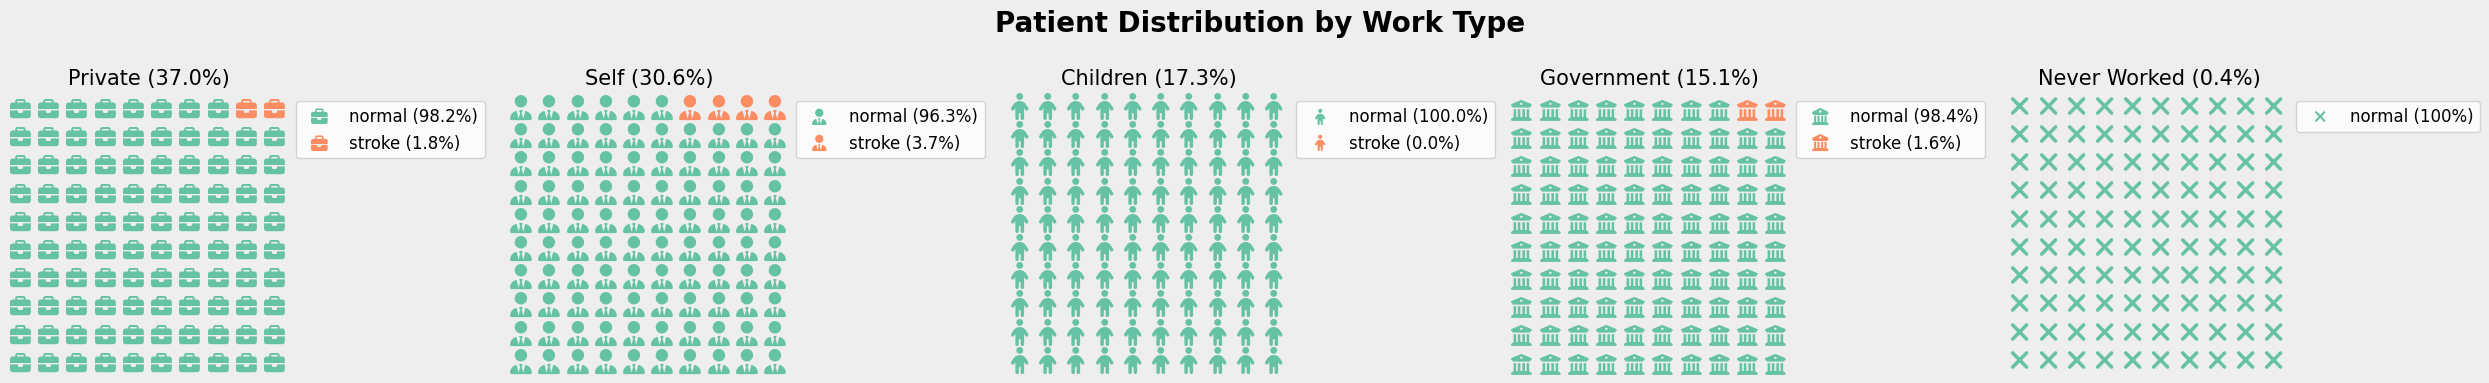

In [206]:
df_sub = df.groupby('stroke')['work_type'].value_counts().copy()

# A glance of hypertension data:
#     stroke  work_type    
#     0       Private          24386
#             Self-employed     6542
#             children          6152
#             Govt_job          5349
#             Never_worked       177
#     1       Private            441
#             Self-employed      251
#             Govt_job            89
#             children             2


private_total = df['work_type'].value_counts()[0]
self_total = df['work_type'].value_counts()[1]
child_total = df['work_type'].value_counts()[2]
govt_total = df['work_type'].value_counts()[3]
none_total = df['work_type'].value_counts()[4]

total = private_total + self_total + child_total + govt_total + none_total

private_normal = round(df_sub[0][0] / private_total * 100, 1)
self_normal = round(df_sub[0][1] / self_total * 100, 1)
child_normal = round(df_sub[0][2] / child_total * 100, 1)
govt_normal = round(df_sub[0][3] / govt_total * 100, 1)
none_normal = round(df_sub[0][4] / none_total * 100)

private_stroke = round(df_sub[1][0] / private_total * 100, 1)
self_stroke = round(df_sub[1][1] / self_total * 100, 1)
child_stroke = round(df_sub[1][3] / child_total * 100, 1)           # df_sub의 stroke[1] 데이터 분포를 확인하면 children과 govt_job 순서가 다름
govt_stroke = round(df_sub[1][2] / govt_total * 100, 1)

private_per = round(never_total / total * 100, 1)
self_per = round(unknown_total / total * 100, 1)
child_per = round(former_total / total * 100, 1)
govt_per = round(smokes_total / total * 100, 1)
none_per = round(none_total / total * 100, 1)


fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    figsize=(25, 25),

    plots={
        151: {
        'values':[private_normal, private_stroke],
        'icons':'briefcase',
        'vertical':True,
        'icon_size':15,
        'icon_legend':True,
        'legend':{
            'labels':[f'normal ({private_normal}%)', f'stroke ({private_stroke}%)'],
            'loc':'upper left',
            'bbox_to_anchor':(1,1),
            'fontsize':12
            },
        'title':{
            'label':f'Private ({private_per}%)',
            'loc':'center',
            'fontsize':15
            }
        },

        152: {
        'values':[self_normal, self_stroke],
        'icons':'user-tie',
        'icon_style':'solid',
        'vertical':True,
        'icon_size':18,
        'icon_legend':True,
        'legend':{
            'labels':[f'normal ({self_normal}%)', f'stroke ({self_stroke}%)'],
            'loc':'upper left',
            'bbox_to_anchor':(1,1),
            'fontsize':12
            },
        'title':{
            'label':f'Self ({self_per}%)',
            'loc':'center',
            'fontsize':15
            }
        },

        153: {
        'values':[child_normal, child_stroke],
        'icons':'child',
        'vertical':True,
        'icon_size':20,
        'icon_legend':True,
        'legend':{
            'labels':[f'normal ({child_normal}%)', f'stroke ({child_stroke}%)'],
            'loc':'upper left',
            'bbox_to_anchor':(1,1),
            'fontsize':12
            },
        'title':{
            'label':f'Children ({child_per}%)',
            'loc':'center',
            'fontsize':15
            }
        },

        154: {
        'values':[govt_normal, govt_stroke],
        'icons':'building-columns',
        'vertical':True,
        'icon_size':15,
        'icon_legend':True,
        'legend':{
            'labels':[f'normal ({govt_normal}%)', f'stroke ({govt_stroke}%)'],
            'loc':'upper left',
            'bbox_to_anchor':(1,1),
            'fontsize':12
            },
        'title':{
            'label':f'Government ({govt_per}%)',
            'loc':'center',
            'fontsize':15
            }
        },

        155: {
        'values':[none_normal],
        'icons':'xmark',
        'vertical':True,
        'icon_size':20,
        'icon_legend':True,
        'legend':{
            'labels':[f'normal ({none_normal}%)'],
            'loc':'upper left',
            'bbox_to_anchor':(1,1),
            'fontsize':12
            },
        'title':{
            'label':f'Never Worked ({none_per}%)',
            'loc':'center',
            'fontsize':15
            }
        }
    }
)

fig.text(.4, .58,'Patient Distribution by Work Type', fontsize=20, fontweight='bold')
fig.set_facecolor('#EEEEEE')

## **ML 모델링**

In [ ]:
!pip3 install imbalanced-learn
!pip install category_encoders

In [ ]:
# test 데이터셋을 hold-out
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, train_size=0.8, random_state=2)

# 모델 학습을 위해 검증 세트를 따로 분류
train, val = train_test_split(train, train_size=0.8, random_state=2)
print('Train set:', train.shape, '\nValidation set:', val.shape, '\nTest set:', test.shape)

In [ ]:
# 타켓의 분포가 
print("Train target distribution:\n", train['stroke'].value_counts(normalize=True), '\n')
print("Val target distribution:\n", val['stroke'].value_counts(normalize=True), '\n')
print("Test target distribution:\n", test['stroke'].value_counts(normalize=True))

In [ ]:
# 타켓 변수와 데이터셋 분리
y = 'stroke' # 타켓 변수

X_train, y_train = train.drop(columns=[y]), train[y]
X_val, y_val = val.drop(columns=[y]), val[y]
X_test, y_test = test.drop(columns=[y]), val[y]

### Baseline Model

In [ ]:
# 환자가 뇌졸중이 있다/없다를 예측하는 2진분류 문제임으로 baseline model로 최빈값(mode)를 사용
mode = [0] # 타겟 변수의 최빈값
y_pred_base = mode * len(y_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_base));

### Decision Tree Classifier

### Random Forest Classifier

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

### Gradient Boosting